In [ ]:
from BTSP_feedback_network import BinaryBTSPfeedbackNetwork
import torch

# ----------------- 创建网络 -----------------
net = BinaryBTSPfeedbackNetwork(
    n_input=10000,
    n_memory=15000,
    fq=0.0025,
    fp=0.005,
    fw=0.6,
    threshold=8,
    fb_threshold=3
)

# ----------------- 生成稀疏输入模式 -----------------
patterns = net.make_sparse_patterns(800)  # 假设 net 已实现 make_sparse_patterns

# ----------------- 训练 -----------------
# 可以指定 Hebbian 学习率
net.train(patterns, lr=0.1)

# ----------------- 测试重构 -----------------
test = patterns[0]

# 前馈激活 CA1
ca1 = net.forward(test)

# 反馈激活 CA3
recon = net.feedback(ca1)

# ----------------- 统计活跃索引 -----------------
active_input_idx = torch.nonzero(test, as_tuple=True)[0]
active_recon_idx = torch.nonzero(recon, as_tuple=True)[0]

print("原始输入 CA3 活跃索引：", active_input_idx.tolist())
print("重构 CA3 活跃索引：", active_recon_idx.tolist())

# ----------------- 计算重构精度 -----------------
# Hamming 距离 / 理论最大活跃数量
hamming = (test != recon).float().sum().item() / (test.sum().item())
print("重构精度:", hamming)


Training (batched):   0%|          | 1/407 [00:01<10:44,  1.59s/it]

反馈激活 CA3 数量: 59.0, 反馈权重总和: 36385.0


Training (batched): 100%|██████████| 407/407 [02:23<00:00,  2.83it/s]


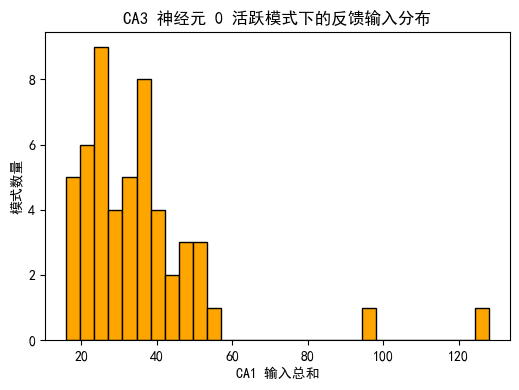

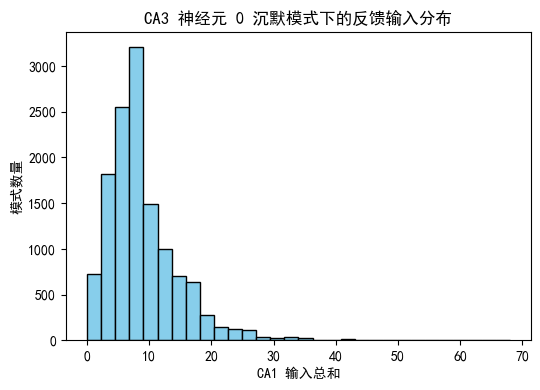

活跃模式: 平均输入总和 = 35.25
沉默模式: 平均输入总和 = 8.950493812561035


In [1]:
import torch
import matplotlib.pyplot as plt
from BTSP_feedback_network import BinaryBTSPfeedbackNetwork
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# ----------------- 创建网络 -----------------
net = BinaryBTSPfeedbackNetwork(
    n_input=10000,
    n_memory=15000,
    fq=0.0025,
    fp=0.005,
    fw=0.6,
    threshold=8,
    fb_threshold=3
)

# ----------------- 生成稀疏输入模式 -----------------
patterns = net.make_sparse_patterns(13000)  # 假设 net 已实现 make_sparse_patterns
net.train(patterns)

ca3_idx = 0  # 要分析的 CA3 神经元索引

active_sums = []
silent_sums = []

for pat in patterns:
    # 前馈激活 CA1
    ca1 = net.forward(pat)
    
    # 计算该 CA3 神经元接收到的 CA1 输入总和
    weights = net.synaptic_fb[ca3_idx] * net.connections_fb[ca3_idx].float()
    input_sum = torch.dot(weights, ca1).item()
    
    if pat[ca3_idx] > 0:  # CA3 在该模式下活跃
        active_sums.append(input_sum)
    else:                 # CA3 沉默
        silent_sums.append(input_sum)


# ----------------- 绘图：活跃模式 -----------------
plt.figure(figsize=(6,4))
plt.hist(active_sums, bins=30, color='orange', edgecolor='k')
plt.xlabel("CA1 输入总和")
plt.ylabel("模式数量")
plt.title(f"CA3 神经元 {ca3_idx} 活跃模式下的反馈输入分布")
plt.show()

# ----------------- 绘图：沉默模式 -----------------
plt.figure(figsize=(6,4))
plt.hist(silent_sums, bins=30, color='skyblue', edgecolor='k')
plt.xlabel("CA1 输入总和")
plt.ylabel("模式数量")
plt.title(f"CA3 神经元 {ca3_idx} 沉默模式下的反馈输入分布")
plt.show()

# ----------------- 输出统计量 -----------------
print("活跃模式: 平均输入总和 =", torch.tensor(active_sums).mean().item())
print("沉默模式: 平均输入总和 =", torch.tensor(silent_sums).mean().item())